In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import time
import warnings
warnings.filterwarnings(action = 'ignore') 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
las_vegas_data= pd.read_pickle('/content/drive/My Drive/las_vegas_data_tokenized.pkl')

In [9]:
start= time.time()
vector = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer= vector.fit_transform(las_vegas_data['tokenized_text'])
print("Time to load data: {} seconds".format(time.time() - start))
# vector.get_feature_names()

Time to load data: 25.650636434555054 seconds


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
scores= pd.DataFrame()

# C= [0.1,1,10,100,1000]
# gamma = [0.1, 1, 10]
# degree= [0,1,2]
C= [0.1,1,10]
X=vectorizer
y=las_vegas_data['label']
dict_accuracy = {}

start= time.time()
for c in C:
  dict_accuracy[c] = []
  print('Started for C=',c)
  svm = LinearSVC(dual=False, max_iter=10000, C=c).fit(X, y)
  print('Finished Modeling for C=',c)
  scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
  dict_accuracy[c].append(scores)
  print('Stored c and scores for C=',c)
  print('Finished for C=', c)

print("Time to load data: {} seconds".format(time.time() - start))

Started for C= 0.1
Finished Modeling for C= 0.1
Stored c and scores for C= 0.1
Finished for C= 0.1
Started for C= 1
Finished Modeling for C= 1
Stored c and scores for C= 1
Finished for C= 1
Started for C= 10
Finished Modeling for C= 10
Stored c and scores for C= 10
Finished for C= 10
Time to load data: 1125.713651418686 seconds


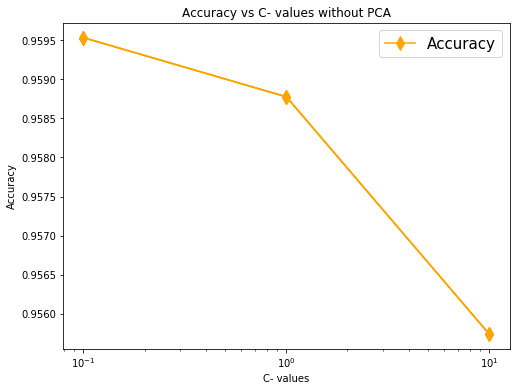

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
for c, x in dict_accuracy.items(): 
    avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy.items()}
    list = sorted(avg_score.items())
    x_plot, y_plot = zip(*list)
    ax.plot(x_plot, y_plot, color='orange',marker='d',markersize=10)

ax.set_ylabel('Accuracy',fontsize=10)
ax.legend(['Accuracy'],loc='upper right',fontsize=15)
ax.set_xlabel('C- values',fontsize=10)
plt.title("Accuracy vs C- values without PCA")
ax.set_xscale('log')
plt.show()

In [0]:
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=30):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['orange' if c < 0 else 'green' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

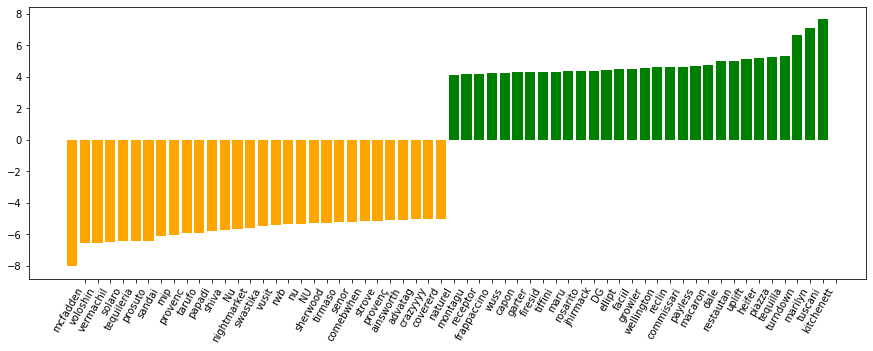

In [14]:
plot_coefficients(svm, vector.get_feature_names())

In [0]:
las_vegas_coefs= pd.DataFrame({'score': svm.coef_[0], 'words': vector.get_feature_names()})
las_vegas_coefs.set_index('words', inplace=True)
las_vegas_coefs= las_vegas_coefs.sort_values(by='score', ascending=False)

In [0]:
las_vegas_coefs

,score
words,
kitchenett,7.653883
tuscani,7.096806
marilyn,6.663722
turndown,5.309450
tequilla,5.254461
...,...
tequileria,-6.452316
solaro,-6.474139
vermachil,-6.578051
